In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
from matplotlib import pyplot as plt
import numpy as np

In [3]:
from IPython.display import Image

In [4]:
import GPy

In [5]:
import sys
sys.path.insert(0, '../source')

In [6]:
from incremental_run import Data, loadData, compute_several_stats, RunFullGP, RunPoE, RunSparseGP

In [8]:
from CPoE import CPoE

In [ ]:
CPoE()

## create some data

In [8]:
kernG = GPy.kern.RBF(input_dim = 1, variance = 1.1, lengthscale = 0.1 )

In [9]:
likG = GPy.likelihoods.Gaussian(variance=0.1)

In [10]:
DD = Data(kern=kernG, sig2_noise=0.2, Ntrain=2**8, Ntest=1000, name='', seed=0, a=0.15);

65.4% test data points IN
timeData  3.869143009185791


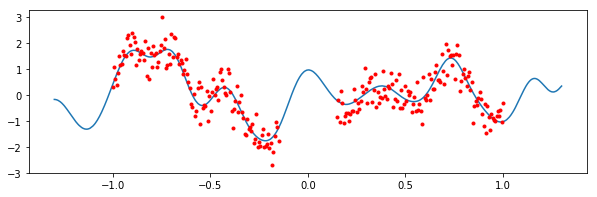

In [11]:
DD.plot_data(figsize=(10,3))

## run full GP as comparison

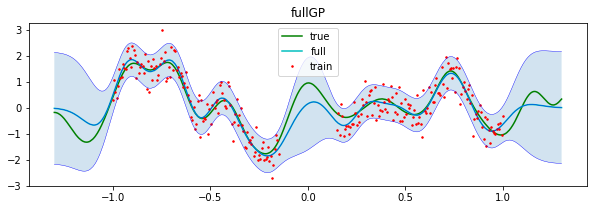

In [12]:
rFullGP = RunFullGP(DD, kernG, likelihood=likG ).run()
rFullGP.plot_full((10,3))

In [13]:
# some statistics computed for test data
# IN/OUT indicates the performence in or outside the regions where training data is available
rFullGP.compute_stats() 

,time,lik,CRPS,errF,errAbs,negLogP,cov,CRPS_IN,errF_IN,errAbs_IN,negLogP_IN,cov_IN,CRPS_OUT,errF_OUT,errAbs_OUT,negLogP_OUT,cov_OUT
fullGP,0.14,-220.974,0.304,0.303,0.208,0.434,0.874,0.269,0.12,0.092,-0.256,0.83,0.372,0.488,0.425,1.74,0.957


## run CPoE algorithm with different degree of correaltions

In [14]:
J = 16           # number of experts
Cs = [1,2,3]     # degrees of correlation
gamma = 0.75     # sparsity parameter

In [15]:
RES1, MOD1 = CPoE(DD.X_train, DD.y_train, kernG, likG, J, Cs[0], gamma, \
                y_test=DD.y_test, X_test=DD.X_test, f_test=DD.f_test)

In [16]:
RES2, MOD2 = CPoE(DD.X_train, DD.y_train, kernG, likG, J, Cs[1], gamma, \
                y_test=DD.y_test, X_test=DD.X_test, f_test=DD.f_test)

In [17]:
RES3, MOD3 = CPoE(DD.X_train, DD.y_train, kernG, likG, J, Cs[2], gamma, \
                y_test=DD.y_test, X_test=DD.X_test, f_test=DD.f_test)

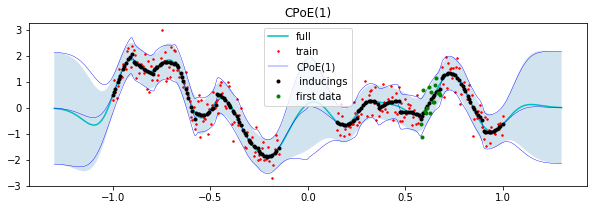

In [18]:
RES1.plot_bgp(rFullGP.m, rFullGP.CI, figsize=(10,3), F_True=False);

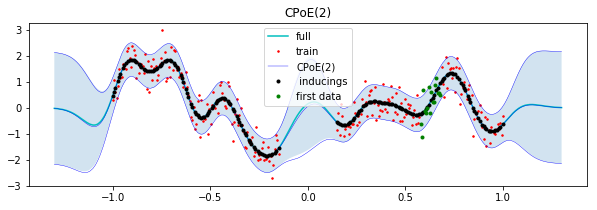

In [19]:
RES2.plot_bgp(rFullGP.m, rFullGP.CI, figsize=(10,3), F_True=False);

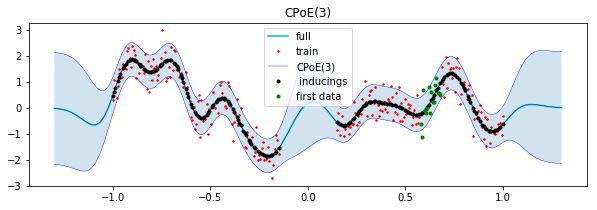

In [20]:
RES3.plot_bgp(rFullGP.m, rFullGP.CI, figsize=(10,3), F_True=False);

In [21]:
compute_several_stats( [RES1,RES2,RES3], mFull=rFullGP.m, vFull=rFullGP.v)

,time,lik,KLx1000,errFull,CRPS,errF,errAbs,negLogP,cov
CPoE(1),0.097,-240.244,18.824,0.095,0.320,0.363,0.251,0.555,0.895
CPoE(2),0.171,-221.321,1.120,0.030,0.307,0.314,0.211,0.451,0.873
CPoE(3),0.623,-220.508,0.215,0.015,0.303,0.298,0.205,0.434,0.876


In [22]:
# consider in particular the column KL to full GP

## comparison with independent PoE methods

In [23]:
namsePoE = np.array(['minVar','PoE-1/J', 'GPoE-scaled','BCM','RBCM'])
argsPartPoE = {'KDTREE':True, 'B_stop':int(DD.Ntrain/J)}

In [24]:
rPoE = RunPoE(DD, J, kernG, likG,  **argsPartPoE)
runsPoE = [rPoE.run(nam) for nam in namsePoE]

In [25]:
compute_several_stats(runsPoE, rFullGP.m, rFullGP.v)

,time,lik,KLx1000,errFull,CRPS,errF,errAbs,negLogP,cov,KL_INx1000,...,errAbs_IN,negLogP_IN,cov_IN,KL_OUTx1000,errFull_OUT,CRPS_OUT,errF_OUT,errAbs_OUT,negLogP_OUT,cov_OUT
minVar,0.383,-240.471,23.452,0.103,0.320,0.365,0.253,0.557,0.891,25.909,...,0.114,-0.151,0.855,18.807,0.139,0.412,0.588,0.515,1.895,0.960
PoE-1/J,0.355,-240.471,479.664,0.433,0.389,0.528,0.418,1.892,0.988,637.164,...,0.344,1.669,0.985,181.963,0.342,0.449,0.660,0.557,2.314,0.994
GPoE-scaled,0.438,-240.471,38.542,0.101,0.317,0.366,0.256,0.746,0.933,47.113,...,0.118,0.129,0.916,22.341,0.146,0.413,0.590,0.517,1.912,0.965
BCM,0.411,-240.471,91.045,0.160,0.347,0.419,0.296,0.500,0.783,104.655,...,0.143,-0.347,0.706,65.318,0.239,0.454,0.667,0.585,2.101,0.928
RBCM,0.396,-240.471,75.495,0.137,0.338,0.399,0.278,0.433,0.801,93.151,...,0.134,-0.403,0.709,42.121,0.208,0.430,0.637,0.549,2.014,0.974


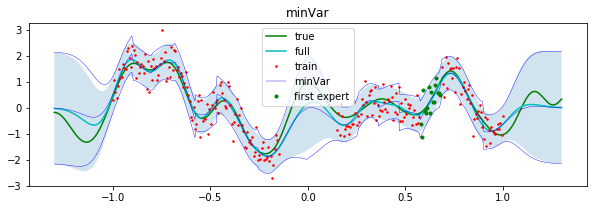

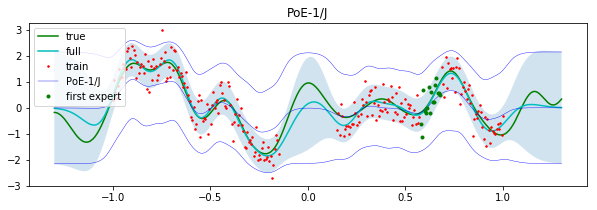

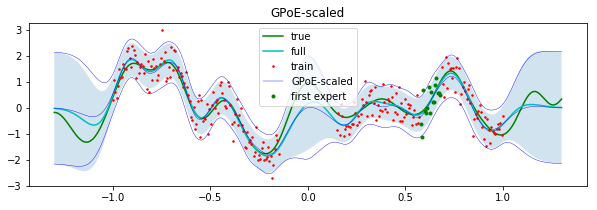

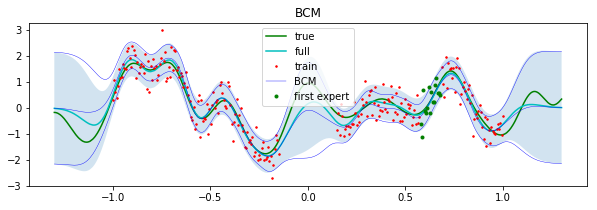

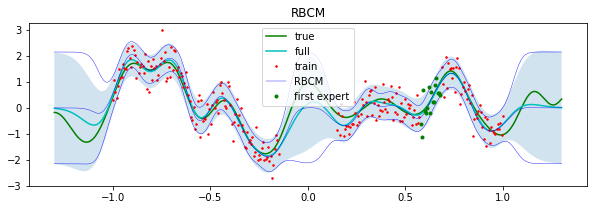

In [26]:
[runsPoE[i].plot_poe(rFullGP.m, rFullGP.CI,figsize=(10,3)) for i in range(len(runsPoE))];

## comparison with gloabl inducing point method

In [27]:
M = 5
MMs = np.array([M, 2*M, 4*M,  5*M, 7*M, 10*M])
runsSparse = [ RunSparseGP(DD, kernG, m, likelihood=likG).run(OPT_TH=False) for m in MMs]

nothing to optimize
nothing to optimize
nothing to optimize
nothing to optimize
nothing to optimize
nothing to optimize


In [28]:
compute_several_stats(runsSparse, rFullGP.m, rFullGP.v)
#compute_several_stats(runsSparse)

,time,lik,KLx1000,errFull,CRPS,errF,errAbs,negLogP,cov,KL_INx1000,...,errAbs_IN,negLogP_IN,cov_IN,KL_OUTx1000,errFull_OUT,CRPS_OUT,errF_OUT,errAbs_OUT,negLogP_OUT,cov_OUT
sparse5,0.571,-2072.804,669.475,0.751,0.504,0.807,0.637,2.208,0.952,910.220,...,0.664,2.103,0.930,214.425,0.377,0.465,0.687,0.585,2.406,0.994
sparse10,0.598,-1322.957,609.191,0.631,0.481,0.745,0.603,1.979,0.889,849.518,...,0.572,1.732,0.835,154.931,0.305,0.499,0.770,0.663,2.446,0.991
sparse20,0.626,-787.656,219.817,0.427,0.372,0.523,0.347,1.035,0.915,269.965,...,0.271,0.479,0.873,125.029,0.281,0.413,0.601,0.492,2.087,0.994
sparse25,0.631,-559.659,144.738,0.330,0.345,0.450,0.301,0.805,0.902,178.563,...,0.191,0.166,0.855,80.804,0.247,0.412,0.604,0.507,2.012,0.991
sparse35,0.705,-240.718,53.054,0.235,0.344,0.457,0.282,0.647,0.874,24.293,...,0.099,-0.183,0.839,107.418,0.382,0.484,0.752,0.628,2.217,0.939
sparse50,0.809,-220.976,0.004,0.001,0.304,0.303,0.208,0.435,0.874,0.000,...,0.092,-0.256,0.830,0.012,0.001,0.372,0.489,0.426,1.742,0.957


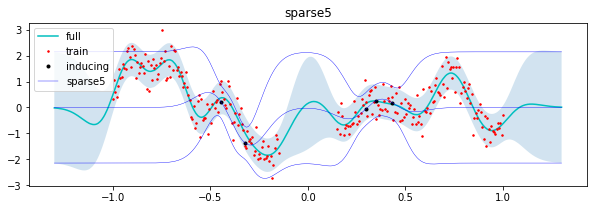

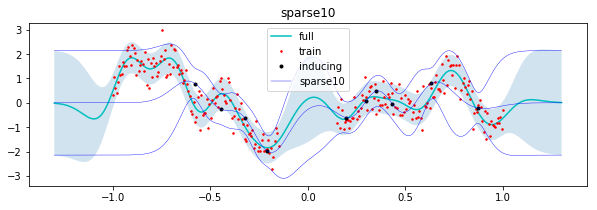

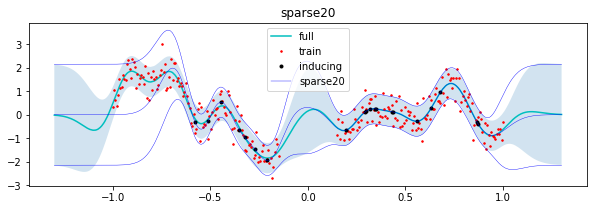

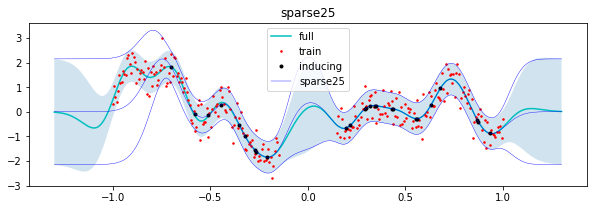

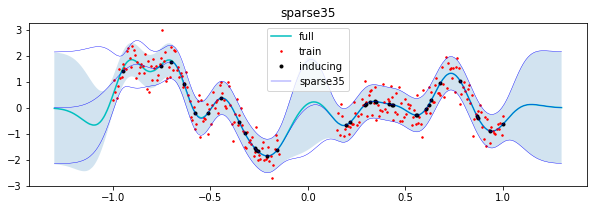

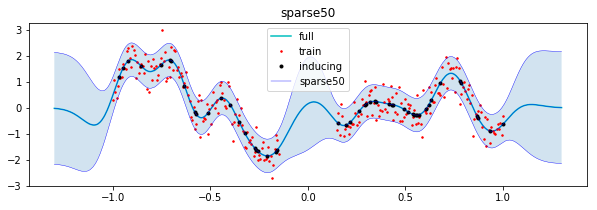

In [29]:
[runsSparse[i].plot_sparse(rFullGP.m, rFullGP.CI, figsize=(10,3), F_True=False) for i in range(len(runsSparse))];

# hyperparameters estimation

In [30]:
# initial kernel and likelihood

In [31]:
kern0 = GPy.kern.RBF(input_dim = 1, variance = 1, lengthscale = 1 )

In [32]:
lik0 = GPy.likelihoods.Gaussian(variance=1)

## finding hyperparameters of full GP

In [33]:
# show GP model with initial parameters
rFullGP_0 = RunFullGP(DD, kern0, likelihood=lik0 ).run(OPT=False)

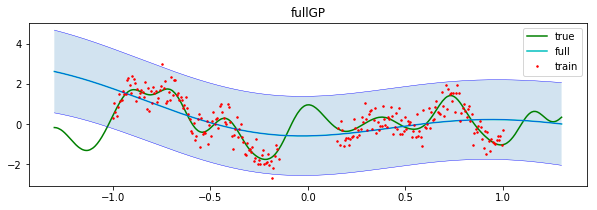

In [34]:
rFullGP_0.plot_full((10,3))

In [35]:
# optimize the hyperparameters
rFullGP_opt = RunFullGP(DD, kern0, likelihood=lik0 ).run(OPT=True)

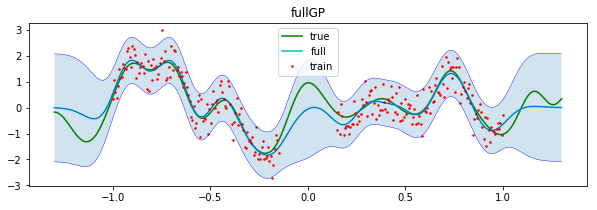

In [36]:
rFullGP_opt.plot_full((10,3))

In [37]:
rFullGP_opt.obj.GPmod

GP_regression.,value,constraints,priors
rbf.variance,0.9341087513276012,+ve,
rbf.lengthscale,0.0943192477834048,+ve,
Gaussian_noise.variance,0.19327346244373234,+ve,


## finding hyperparameters of CPoE

#### deterministic optimization

In [38]:
# optimize hyperparameters of CPoE with deterministic optimization involving the whole dataset
RES_det, MOD_det = CPoE(DD.X_train, DD.y_train, kern0, lik0, J, 3, gamma, HYPERS='BATCH', \
                y_test=DD.y_test, X_test=DD.X_test, f_test=DD.f_test)

In [39]:
MOD_det.kern

rbf.,value,constraints,priors
variance,0.9639163655585999,+ve,
lengthscale,0.09865910003219161,+ve,


In [40]:
MOD_det.lik

Gaussian_noise.,value,constraints,priors
variance,0.19864010719000535,+ve,


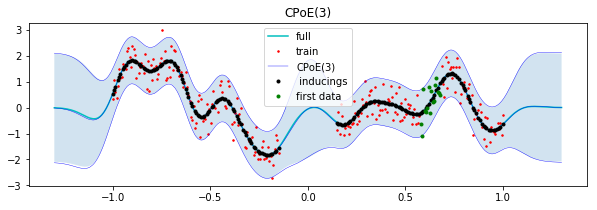

In [41]:
RES_det.plot_bgp(rFullGP_opt.m, rFullGP_opt.CI, figsize=(10,3), F_True=False);

#### stochastic optimization

In [42]:
# optimize hyperparameters of CPoE with stochastic optimization involving only mini-batches
RES_stoch, MOD_stoch = CPoE(DD.X_train, DD.y_train, kern0, lik0, J, 3, gamma, HYPERS='STOCH', \
                y_test=DD.y_test, X_test=DD.X_test, f_test=DD.f_test,\
                gamma=0.01, E=60, jit=1e-3, B_increase=False, REL=1e-10)

'Epoch 59 likelihood: -208.38764314915198 rel: 5.555220857466396e-05 stop?: False'

In [43]:
MOD_stoch.kern

rbf.,value,constraints,priors
variance,0.9910146605556074,+ve,
lengthscale,0.10113782258237354,+ve,


In [44]:
MOD_stoch.lik

Gaussian_noise.,value,constraints,priors
variance,0.1975905259091444,+ve,


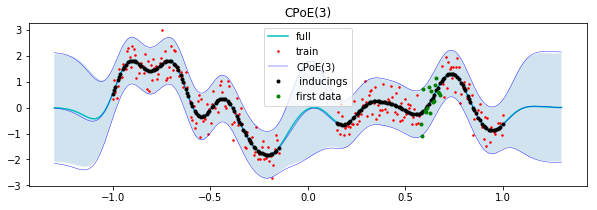

In [45]:
RES_stoch.plot_bgp(rFullGP_opt.m, rFullGP_opt.CI, figsize=(10,3), F_True=False);